# This notebook aims to separate individual bean images from the cluster pictures gathered.

In [9]:
import cv2
import os


def split_beans(in_path, out_dir, group_img_index, verbose=False):
    """
    This function does the following:
        - read the raw image at the path
        - find regions containing individual coffee beans
        - store each region in its own path
    @param in_path the path to the input image
    @param out_dir the path at which the resulting images are to be stored
    @param group_img_index the number of the input image relative to its folder, needed to avoid duplicate image names in the resulting folder
    """
    img = cv2.imread(in_path)
    gray = cv2.cvtColor(
        img, cv2.COLOR_RGB2GRAY
    )  # Grayscale the image. Note that the background is white and the beans are dark. This will be important down the line

    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.bitwise_not(
        thresh
    )  # OpenCV needs the blobs to be white and the background to be black in order to find the contours. Flip the now bw image

    result = img.copy()
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    bounding_rects = filter(
        lambda c: c[2] * c[3] >= 10000 and c[2] / c[3] < 3.0 and c[3] / c[2] < 3.0,
        map(cv2.boundingRect, contours),
    )  # This is a bit crude, but filter out contours of specs of dust, etc and make sure only actual beans remain highlighted. Since the bounding rectangles are **roughly** square, this corresponds to a roughly 100x100 image. Also, filter out regions that are really misshapen and are unlikely to contain a bean - such as a long shadow or the edge of the background

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    for i, (x, y, w, h) in enumerate(bounding_rects):
        if verbose:
            print(f"Region {i}\nx: {x}, y: {y}, width: {w}, height: {h}")
            print(f"area: {w * h}")
            print("-----------------------------------------------------")
            print("Storing to", f"{out_dir}/bean-{group_img_index}-{i}.png")
        bean = result[
            y : y + h, x : x + w
        ]  # Chop off the portion of the image around the given contour and save in its own file
        cv2.imwrite(f"{out_dir}/bean-{group_img_index}-{i}.png", bean)

In [10]:
bean_dirs = [folder for folder in os.listdir("data/raw") if not folder.startswith(".")]
for dir in bean_dirs:
    img_paths = os.listdir(f"data/raw/{dir}")
    for index, path in enumerate(img_paths):
        split_beans(f"data/raw/{dir}/{path}", f"data/processed/{dir}", index)

Region 0
x: 786, y: 2315, width: 375, height: 296
area: 111000
-----------------------------------------------------
Storing to data/processed/columbia-caturra-washed-burnt/bean-0-0.png
Region 1
x: 1557, y: 2210, width: 469, height: 380
area: 178220
-----------------------------------------------------
Storing to data/processed/columbia-caturra-washed-burnt/bean-0-1.png
Region 0
x: 1745, y: 2373, width: 604, height: 477
area: 288108
-----------------------------------------------------
Storing to data/processed/columbia-caturra-washed-burnt/bean-1-0.png
Region 1
x: 653, y: 2208, width: 474, height: 377
area: 178698
-----------------------------------------------------
Storing to data/processed/columbia-caturra-washed-burnt/bean-1-1.png
Region 0
x: 1762, y: 3233, width: 264, height: 227
area: 59928
-----------------------------------------------------
Storing to data/processed/ethiopia-ethHeirloom-washed-normal/bean-0-0.png
Region 1
x: 1295, y: 3232, width: 269, height: 244
area: 65636


# Report statistics on the dataset

In [38]:
def get_non_hidden_folders(path):
    return [f for f in os.listdir(path) if not f.startswith(".")]

## Number of beans per origin

In [39]:
origins = [path.split("-")[0] for path in get_non_hidden_folders("data/processed")]
origins = set(origins)
origin_counts = {}
for origin in origins:
    origin_counts[origin] = sum(
        [
            len(os.listdir(f"data/processed/{folder}"))
            for folder in get_non_hidden_folders("data/processed")
            if origin in folder
        ]
    )

origin_counts

{'brazil': 449,
 'peru': 502,
 'columbia': 395,
 'guatemala': 150,
 'kenya': 239,
 'ethiopia': 979,
 'ecuador': 77}

## Number of beans per defect

In [40]:
defects = [path.split("-")[3] for path in get_non_hidden_folders("data/processed")]
defects = set(defects)
defect_counts = {}
for defect in defects:
    defect_counts[defect] = sum(
        [
            len(os.listdir(f"data/processed/{folder}"))
            for folder in get_non_hidden_folders("data/processed")
            if defect in folder
        ]
    )

defect_counts

{'frag': 296,
 'quaker': 983,
 'burnt': 50,
 'insect': 45,
 'under': 104,
 'mold': 2,
 'normal': 1311}

## Number of beans per processing method

In [41]:
methods = [path.split("-")[2] for path in get_non_hidden_folders("data/processed")]
methods = set(methods)
method_counts = {}
for method in methods:
    method_counts[method] = sum(
        [
            len(os.listdir(f"data/processed/{folder}"))
            for folder in get_non_hidden_folders("data/processed")
            if method in folder
        ]
    )

method_counts

{'washed': 1690,
 'anaerobicNat': 77,
 'honey': 150,
 'fruitInfused': 154,
 'CM': 271,
 'nat': 449}

## Number of beans per variety

In [42]:
varieties = [path.split("-")[1] for path in get_non_hidden_folders("data/processed")]
varieties = set(varieties)
variety_counts = {}
for variety in varieties:
    variety_counts[variety] = sum(
        [
            len(os.listdir(f"data/processed/{folder}"))
            for folder in get_non_hidden_folders("data/processed")
            if variety in folder
        ]
    )

variety_counts

{'wushwush': 164,
 'catuai': 285,
 'yirga': 271,
 'sl28': 239,
 'typica': 77,
 'ethHeirloom': 505,
 'guji': 203,
 'caturra': 897,
 'redBourbon': 150}

# Visualise bean counts

Text(0.5, 1.0, 'Bean defects')

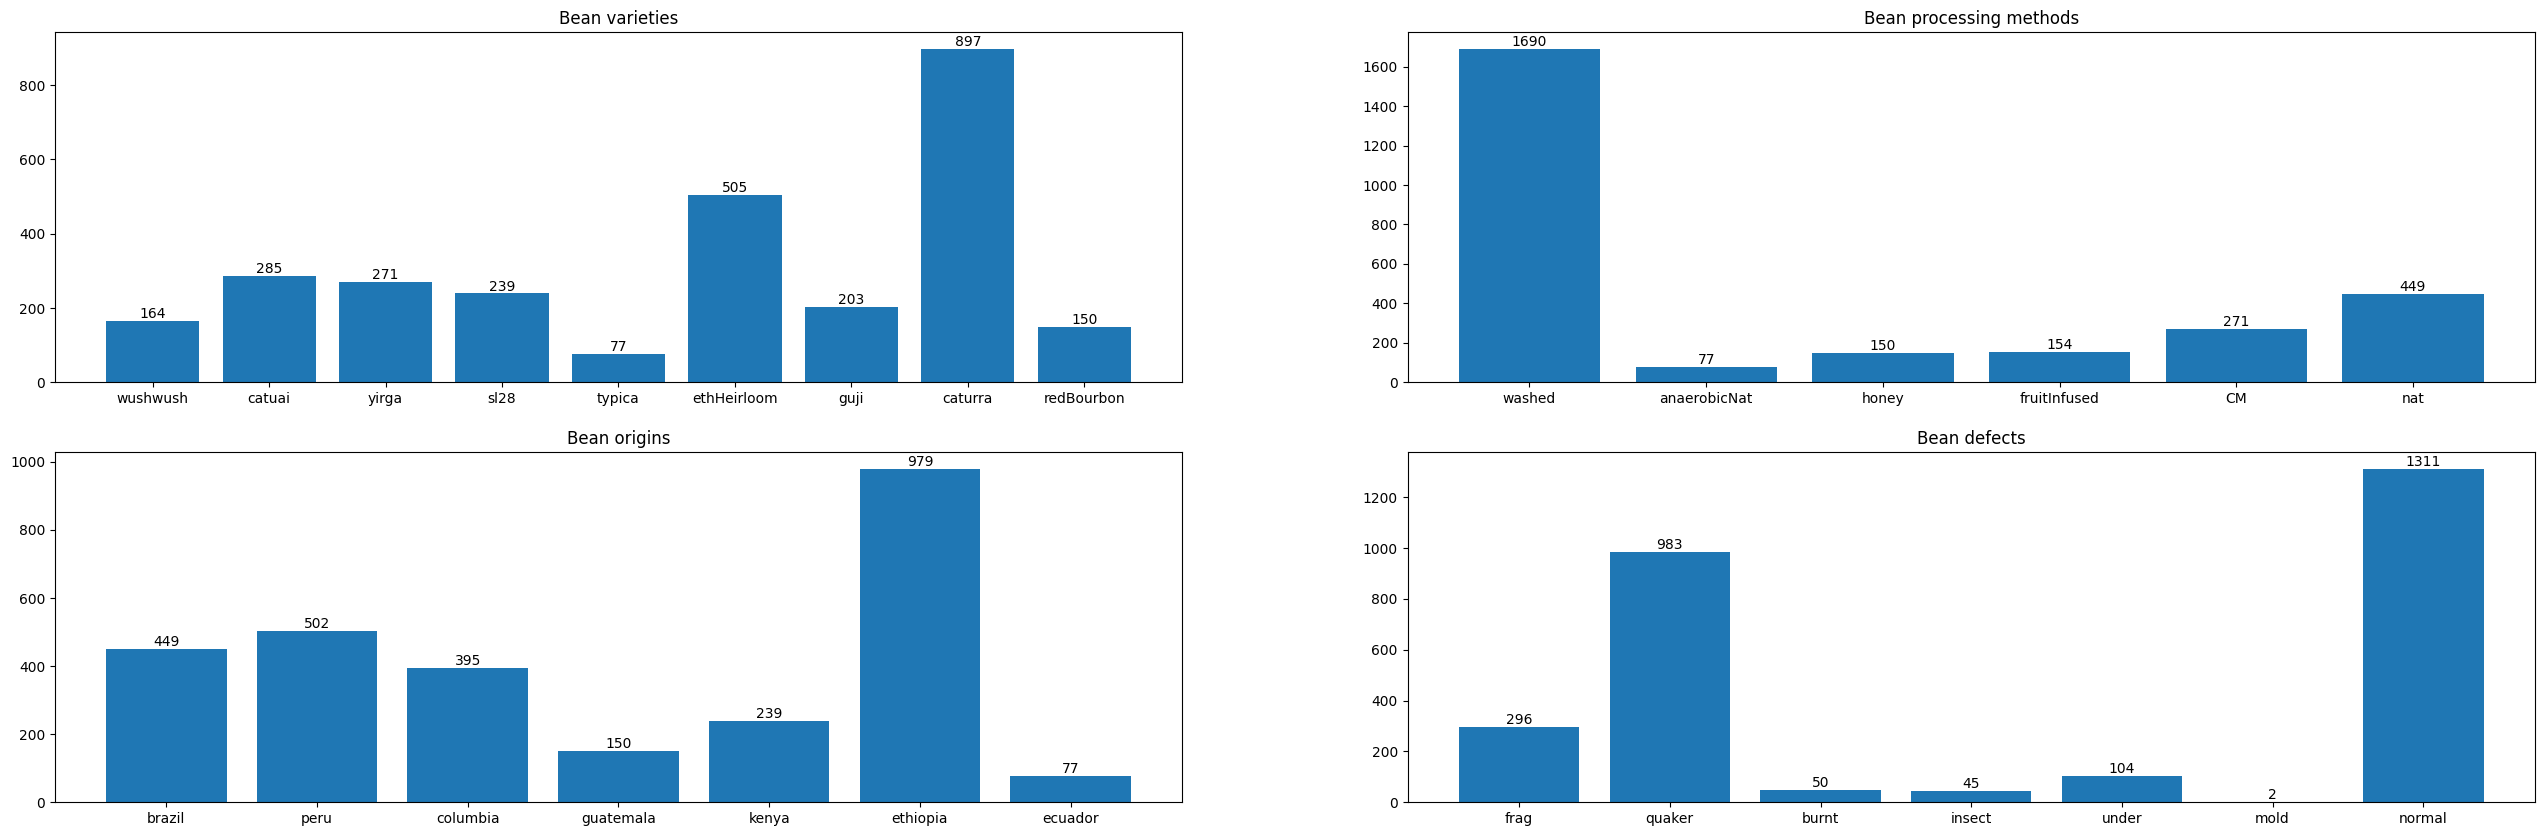

In [56]:
import matplotlib.pyplot as plt


def plot_dict(input: dict, ax) -> None:
    keys = list(input.keys())
    values = list(input.values())
    ax.bar_label(ax.bar(range(len(keys)), values, tick_label=keys))


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(32, 10))

plot_dict(variety_counts, ax1)
ax1.set_title("Bean varieties")
plot_dict(method_counts, ax2)
ax2.set_title("Bean processing methods")
plot_dict(origin_counts, ax3)
ax3.set_title("Bean origins")
plot_dict(defect_counts, ax4)
ax4.set_title("Bean defects")